# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import os

import shutil
import random
from pathlib import Path


In [2]:
print(tf.config.list_physical_devices('GPU'))


[]


# Data download and preprocess

In [54]:
COLAB = False  # if True, run on Google Colab, else on local repository
FAM_SPLIT = False  # if True, split the dataset by family, else by class


In [55]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
APPLY_DATA_AUGMENTATION = False
N_EPOCHS = 20
VERBOSE = True


IF RUNNING ON COLAB

In [ ]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
if COLAB:
    # if running on Google Colab
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        shuffle_files=True,
        as_supervised=True,  # returns (image, label) pairs
        with_info=True,
    )


In [ ]:
# Show example from the dataset
tfds.show_examples(ds_train, ds_info)


NameError: name 'ds_train' is not defined

In [ ]:
#define class_names as folders names
class_names = ds_info.features['label'].names
if VERBOSE:
  print(class_names)


NameError: name 'ds_info' is not defined

In [ ]:
#families counter

if FAM_SPLIT:
  counter = 0
  families = sorted({name.split('___')[0] for name in class_names})
  split_labels = families
  if VERBOSE:
    print(families)
    print(len(families))
else:
  split_labels = class_names

NUM_LAB = len(split_labels)


NameError: name 'class_names' is not defined

In [ ]:
#index assignment for each family

if FAM_SPLIT:
  family_map = [
    families.index(name.split('___')[0])
    for name in class_names
  ]

  family_map = tf.constant(family_map, dtype=tf.int32)

  if VERBOSE:
    print(family_map)


NameError: name 'class_names' is not defined

In [ ]:
#folder name -> family index (Apple = 1, Blueberry = 2 etc.)
def folder_to_fam_ohe(image, label):
  fam_index = tf.gather(family_map, label)
  fam_ohe = tf.one_hot(fam_index, NUM_LAB)
  return image, fam_ohe


In [92]:
if FAM_SPLIT:
    ds_train_ohe = ds_train.map(folder_to_fam_ohe)
    ds_val_ohe = ds_val.map(folder_to_fam_ohe)
    ds_test_ohe = ds_test.map(folder_to_fam_ohe)


NameError: name 'ds_train' is not defined

In [ ]:
def preprocess(image, label, image_size=(128, 128)):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_with_ohe(image, label, image_size=(128, 128)):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, dataset_info.features['label'].num_classes)


In [76]:
# Preprocess and batch the datasets
if FAM_SPLIT:
    if APPLY_DATA_AUGMENTATION:
        print("Data augmentation is enabled.")
        train_ds_ohe = ds_train_ohe.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation
    else:
        print("Data augmentation is disabled.")
        ds_train_ohe = ds_train_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation

    ds_val_ohe = ds_val_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    ds_test_ohe = ds_test_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
else:
    if APPLY_DATA_AUGMENTATION:
        print("Data augmentation is enabled.")
        train_ds_ohe = ds_train_ohe.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation
    else:
        print("Data augmentation is disabled.")
        ds_train_ohe = ds_train_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation

    ds_val_ohe = ds_val_ohe.map(preprocess_with_ohe).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    ds_test_ohe = ds_test_ohe.map(preprocess_with_ohe).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Data augmentation is disabled.


In [ ]:
print(ds_train_ohe)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 14), dtype=tf.float32, name=None))>


IF RUNNING ON LOCAL REPOSITORY

In [56]:
#SOURCE_DIR   = Path(r"/home/luchino/Desktop/ProgettoML/PlantVillage-Dataset/raw/color")
SOURCE_DIR   = Path(r"D:\progetto-daml\PlantVillage-Dataset\raw\color") 


In [ ]:
#ONLY RUN IF DATASET IS NOT SPLIT YET

if FAM_SPLIT:
    # 1) Configurazione
    #SOURCE_DIR   = Path(r"D:\progetto-daml\PlantVillage-Dataset\raw\color")
    #OUTPUT_ROOT  = Path(r"D:\progetto-daml\PlantVillage-Dataset\by_family")
    OUTPUT_ROOT  = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_family")
    TRAIN_FRAC   = 0.8
    VAL_FRAC     = 0.1
    TEST_FRAC    = 0.1
    SEED         = 42

    random.seed(SEED)

    # 2) Crea le directory di output
    for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

    # 3) Raccogli classi di disease e mappa a famiglia
    disease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])
    families = sorted({d.name.split("___")[0] for d in disease_folders})

    # 4) Prepara le cartelle per ogni famiglia e split
    for split in ("train","val","test"):
        for fam in families:
            (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)

    # 5) Per ogni disease, raccogli i file e spartiscili
    for disease_dir in disease_folders:
        fam = disease_dir.name.split("___")[0]
        images = list(disease_dir.glob("*.*"))  # tutti i file immagine
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * VAL_FRAC)
        # il resto va in test
        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copia fisica in output_root/<split>/<fam>/
        for img in train_imgs:
            shutil.copy(img, OUTPUT_ROOT/"train"/fam/img.name)
        for img in val_imgs:
            shutil.copy(img, OUTPUT_ROOT/"val"/fam/img.name)
        for img in test_imgs:
            shutil.copy(img, OUTPUT_ROOT/"test"/fam/img.name)

    print("Done! I tuoi dati sono ora in:\n",
        OUTPUT_ROOT / "train", OUTPUT_ROOT / "val", OUTPUT_ROOT / "test")

else:
    OUTPUT_ROOT  = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_disease")
    TRAIN_FRAC   = 0.8
    VAL_FRAC     = 0.1
    TEST_FRAC    = 0.1
    SEED         = 42

    random.seed(SEED)

    # 2) Crea le directory di output (train, val, test)
    for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

    # 3) Preleva tutte le cartelle “disease” (una per classe)
    disease_dirs = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])

    # 4) Prepara le sottocartelle per ciascuna classe in ogni split
    for split in ("train","val","test"):
        for disease_dir in disease_dirs:
            class_name = disease_dir.name
            (OUTPUT_ROOT / split / class_name).mkdir(parents=True, exist_ok=True)

    # 5) Per ogni classe, raccogli i file e spartiscili
    for disease_dir in disease_dirs:
        class_name = disease_dir.name
        images = list(disease_dir.glob("*.*"))  # tutti i file immagine
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * VAL_FRAC)
        # il resto va in test
        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copia fisica in output_root/<split>/<class_name>/
        for img in train_imgs:
            shutil.copy(img, OUTPUT_ROOT/"train"/class_name/img.name)
        for img in val_imgs:
            shutil.copy(img, OUTPUT_ROOT/"val"/class_name/img.name)
        for img in test_imgs:
            shutil.copy(img, OUTPUT_ROOT/"test"/class_name/img.name)

        print("Done! I tuoi dati sono ora in:\n",
        OUTPUT_ROOT / "train", OUTPUT_ROOT / "val", OUTPUT_ROOT / "test")


Done! I tuoi dati sono ora in:
 /home/luchino/Desktop/ProgettoML/Dataset/by_family/train /home/luchino/Desktop/ProgettoML/Dataset/by_family/val /home/luchino/Desktop/ProgettoML/Dataset/by_family/test


In [58]:
import tensorflow as tf
if FAM_SPLIT:
    OUTPUT_ROOT = Path(r"D:\progetto-daml\PlantVillage-Dataset\by_family")
    #OUTPUT_ROOT = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_family")
else:
    #OUTPUT_ROOT = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_disease")
    OUTPUT_ROOT = Path(r"D:\progetto-daml\PlantVillage-Dataset\by_disease")


IMG_SIZE   = (128,128)
BATCH_SIZE = 32
SEED       = 42

ds_train_ohe = tf.keras.utils.image_dataset_from_directory(
    str(OUTPUT_ROOT/"train"),
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,  # mescola le immagini
    label_mode='categorical',  # ottieni one-hot su len(families)
)

ds_val_ohe = tf.keras.utils.image_dataset_from_directory(
    str(OUTPUT_ROOT/"val"),
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
)

ds_test_ohe = tf.keras.utils.image_dataset_from_directory(
    str(OUTPUT_ROOT/"test"),
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
)


Found 43429 files belonging to 38 classes.
Found 5417 files belonging to 38 classes.
Found 5459 files belonging to 38 classes.


In [59]:
# SOURCE_DIR punta alla cartella che contiene le sottocartelle di tutte le classi “disease”
# es. D:/progetto-daml/PlantVillage-Dataset/raw/color
disease_dirs = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])
family_dirs = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])

if FAM_SPLIT:
    # Estrai il prefisso “famiglia” daN_EPOCHS = 12 ogni cartella disease (prima di ___)
    split_labels = sorted({d.name.split("___")[0] for d in disease_dirs})
else:
    # Usa direttamente i nomi delle cartelle disease
    split_labels = [d.name for d in disease_dirs]

print(f"Numero di classi = {len(split_labels)}")
print(split_labels)


Numero di classi = 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust_', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mo

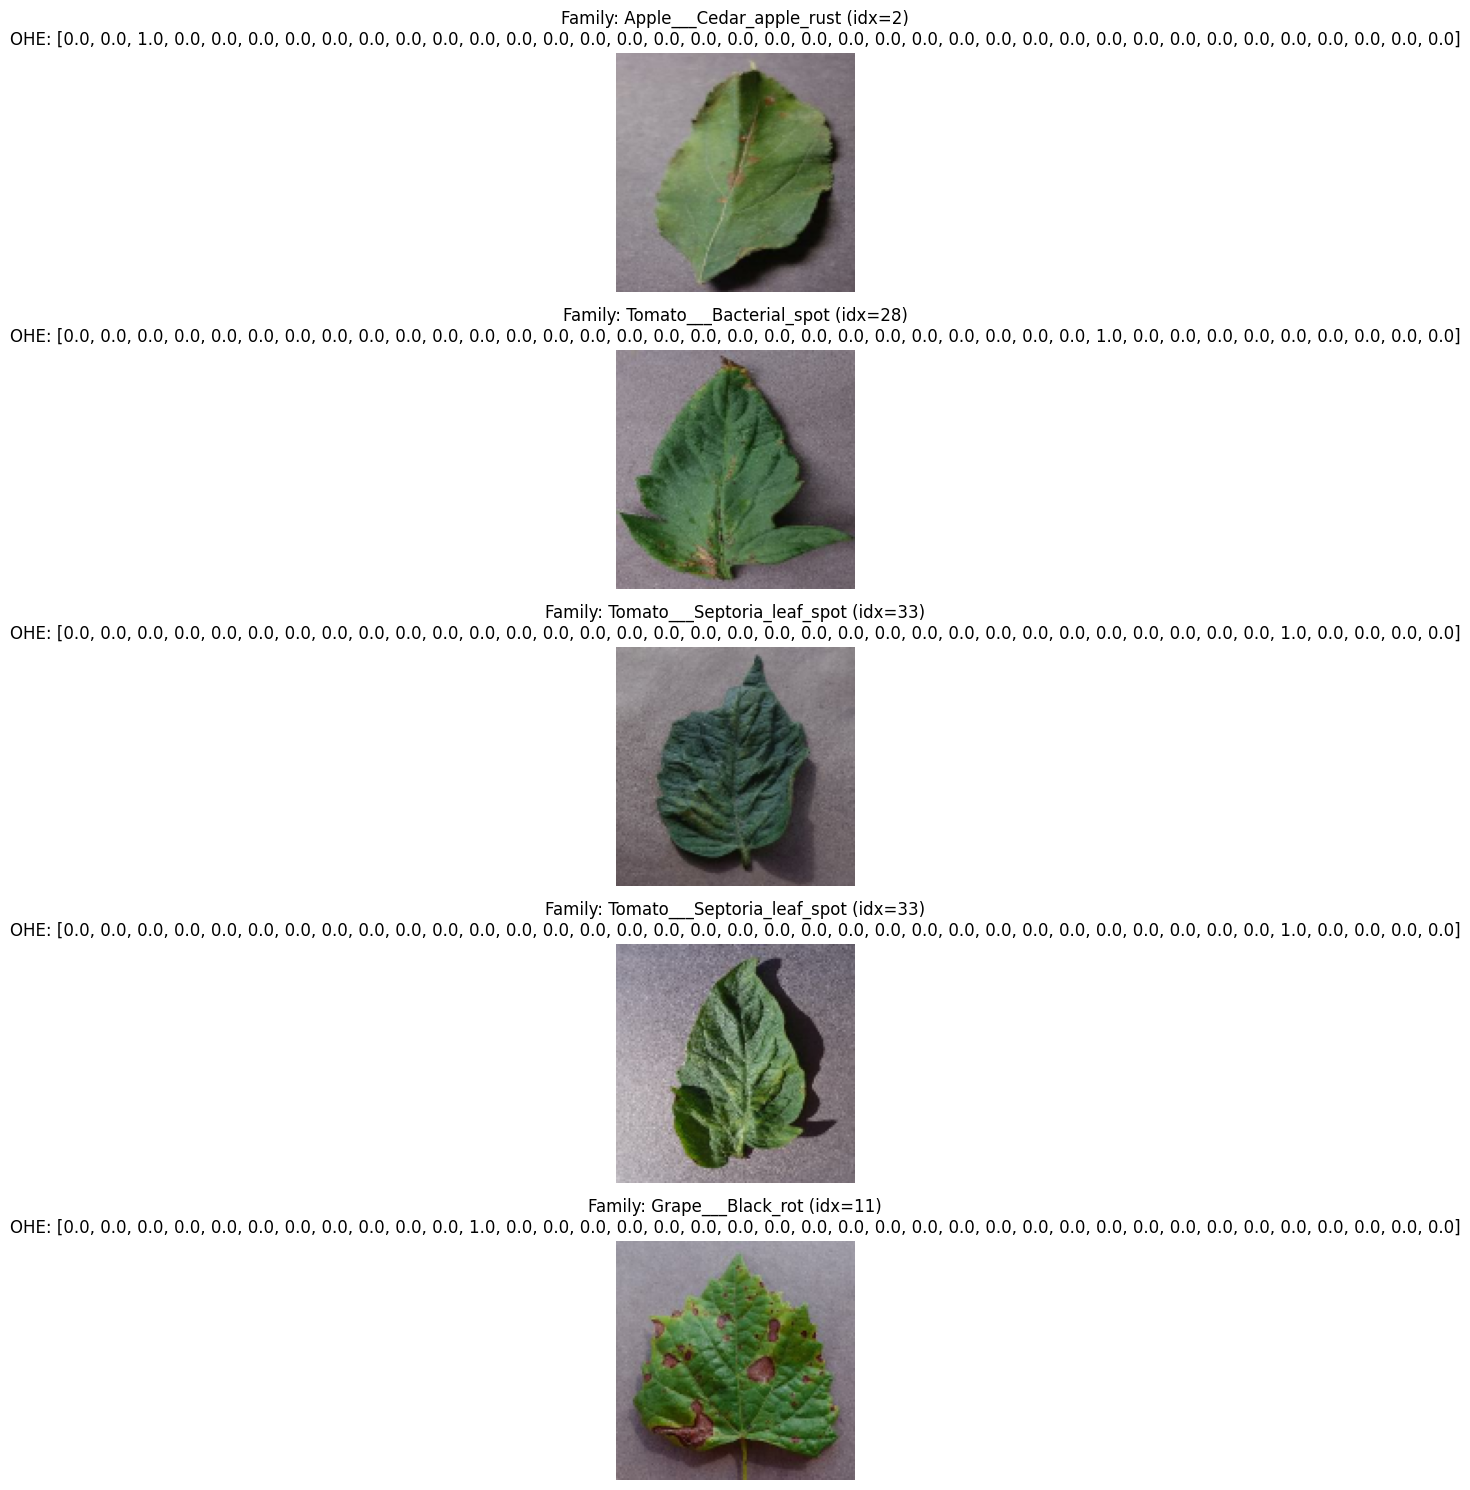

In [60]:
# Assicurati di avere la lista 'families' definita, per es.:
# families = ['Apple', 'Blueberry', …]  # lunghezza NUM_FAM

def display_samples_with_labels_ohe(dataset, num_samples=5):
    plt.figure(figsize=(6, 3 * num_samples))
    for i, (img, label_ohe) in enumerate(dataset.unbatch().take(num_samples)):
        # Converte i tensori in NumPy
        img_np   = img.numpy().astype("uint8")
        ohe_vec  = label_ohe.numpy()                     # vettore one-hot
        fam_idx  = int(tf.argmax(label_ohe).numpy())     # indice famiglia
        fam_name = split_labels[fam_idx]

        # Plot
        ax = plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Family: {fam_name} (idx={fam_idx})\nOHE: {ohe_vec.tolist()}")
    plt.tight_layout()
    plt.show()

# Esempio d’uso:
display_samples_with_labels_ohe(ds_train_ohe, num_samples=5)


# CNN model definition

In [61]:
# Extract only labels (not images) for counting

import numpy as np
from collections import Counter

# Usa Counter per efficienza in memoria e velocità
counts = Counter()

for _, batch_labels in ds_train_ohe:
    # batch_labels.numpy() ha shape (batch_size, num_classes)
    idxs = np.argmax(batch_labels.numpy(), axis=1)  # shape (batch_size,)
    counts.update(idxs)

print(f"Number of classes: {len(split_labels)}")
print("Number of images per class:")
for idx in range(len(split_labels)):
    print(f"{split_labels[idx]}: {counts[idx]} images")

'''
import pandas as pd
labels_list = []
for _, label in ds_train_ohe:
    labels_list.append(label.numpy())

# Convert to pandas Series for fast operations
labels_series = pd.Series(labels_list)

#number_of_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {len(split_labels)}")
#class_names = ds_info.features['label'].names

# Count using pandas (fast) but memory-efficient
class_counts = labels_series.value_counts().sort_index()

# Print the counts with class names
print("Number of images per class:")
for idx, count in class_counts.items():
    print(f"{split_labels[idx]}: {count} images")
'''

Number of classes: 38
Number of images per class:
Apple___Apple_scab: 504 images
Apple___Black_rot: 496 images
Apple___Cedar_apple_rust: 220 images
Apple___healthy: 1316 images
Blueberry___healthy: 1201 images
Cherry___healthy: 841 images
Cherry___Powdery_mildew: 683 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 410 images
Corn___Common_rust_: 953 images
Corn___healthy: 788 images
Corn___Northern_Leaf_Blight: 929 images
Grape___Black_rot: 944 images
Grape___Esca_(Black_Measles): 1106 images
Grape___healthy: 860 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 338 images
Orange___Haunglongbing_(Citrus_greening): 4405 images
Peach___Bacterial_spot: 1837 images
Peach___healthy: 288 images
Pepper,_bell___Bacterial_spot: 797 images
Pepper,_bell___healthy: 1182 images
Potato___Early_blight: 800 images
Potato___healthy: 800 images
Potato___Late_blight: 121 images
Raspberry___healthy: 296 images
Soybean___healthy: 4072 images
Squash___Powdery_mildew: 1468 images
Strawberry___healthy: 88

'\nimport pandas as pd\nlabels_list = []\nfor _, label in ds_train_ohe:\n    labels_list.append(label.numpy())\n\n# Convert to pandas Series for fast operations\nlabels_series = pd.Series(labels_list)\n\n#number_of_classes = ds_info.features[\'label\'].num_classes\nprint(f"Number of classes: {len(split_labels)}")\n#class_names = ds_info.features[\'label\'].names\n\n# Count using pandas (fast) but memory-efficient\nclass_counts = labels_series.value_counts().sort_index()\n\n# Print the counts with class names\nprint("Number of images per class:")\nfor idx, count in class_counts.items():\n    print(f"{split_labels[idx]}: {count} images")\n'

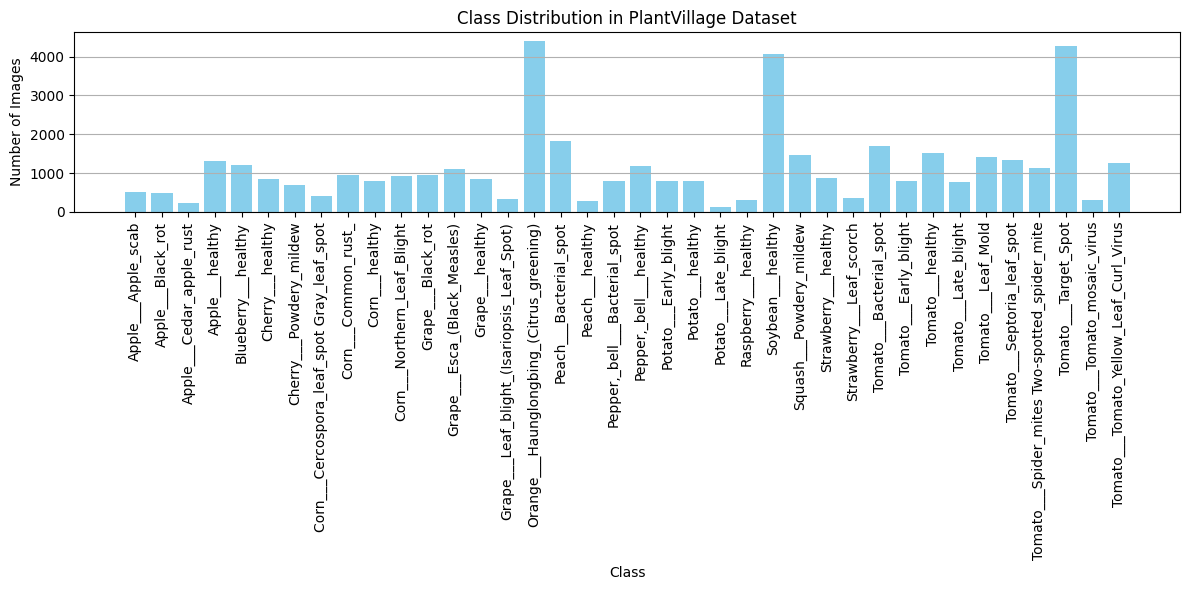

In [62]:
# Visualize the class distribution
counts_list = [counts[i] for i in range(len(split_labels))]

plt.figure(figsize=(12, 6))
plt.bar(split_labels, counts_list, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in PlantVillage Dataset')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [63]:
from keras.models import Sequential, Model
from keras.layers import Resizing, Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import regularizers


In [79]:
#model definition
def simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=len(split_labels)):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model



In [80]:
model = simple_cnn()
model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,142,470 (8.17 MB)

 Trainable params: 2,142,118 (8.17 MB)

 Non-trainable params: 352 (1.38 KB)

In [81]:
optimizer = Adam(learning_rate=0.001)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
if APPLY_DATA_AUGMENTATION:
    check_point_filename = 'best_model_w_augmentation.h5'
else:
    check_point_filename = 'best_model_wo_augmentation.h5'


In [82]:
# Element format
print("Element spec:", ds_train_ohe.element_spec)

# Example on a batch
for batch in ds_train_ohe.take(1):
    x, y = batch
    print("x shape:", x.shape, "  dtype:", x.dtype)
    print("y shape:", y.shape, "  dtype:", y.dtype)


Element spec: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))
x shape: (32, 128, 128, 3)   dtype: <dtype: 'float32'>
y shape: (32, 38)   dtype: <dtype: 'float32'>


In [83]:
history = model.fit(
    ds_train_ohe,
    validation_data=ds_val_ohe,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(check_point_filename, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)


Epoch 1/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.2369 - loss: 3.1047
Epoch 1: val_loss improved from inf to 2.14990, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 480s 351ms/step - accuracy: 0.2370 - loss: 3.1043 - val_accuracy: 0.3751 - val_loss: 2.1499 - learning_rate: 0.0010
Epoch 2/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.3811 - loss: 2.1099
Epoch 2: val_loss did not improve from 2.14990
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 462s 340ms/step - accuracy: 0.3811 - loss: 2.1098 - val_accuracy: 0.3624 - val_loss: 2.3067 - learning_rate: 0.0010
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.4437 - loss: 1.8590
Epoch 3: val_loss improved from 2.14990 to 1.93850, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 451s 332ms/step - accuracy: 0.4437 - loss: 1.8590 - val_accuracy: 0.4430 - val_loss: 1.9385 - learning_rate: 0.0010
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4996 - loss: 1.6570
Epoch 4: val_loss did not improve from 1.93850
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 482s 355ms/step - accuracy: 0.4996 - loss: 1.6570 - val_accuracy: 0.4421 - val_loss: 1.9859 - learning_rate: 0.0010
Epoch 5/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.5408 - loss: 1.5101
Epoch 5: val_loss improved from 1.93850 to 1.86363, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 451s 332ms/step - accuracy: 0.5408 - loss: 1.5101 - val_accuracy: 0.4648 - val_loss: 1.8636 - learning_rate: 0.0010
Epoch 6/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.5706 - loss: 1.3962
Epoch 6: val_loss did not improve from 1.86363
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 453s 333ms/step - accuracy: 0.5706 - loss: 1.3962 - val_accuracy: 0.4456 - val_loss: 2.1254 - learning_rate: 0.0010
Epoch 7/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5895 - loss: 1.3154
Epoch 7: val_loss improved from 1.86363 to 1.63240, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 501s 369ms/step - accuracy: 0.5895 - loss: 1.3154 - val_accuracy: 0.5298 - val_loss: 1.6324 - learning_rate: 0.0010
Epoch 8/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6105 - loss: 1.2540
Epoch 8: val_loss did not improve from 1.63240
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 702s 517ms/step - accuracy: 0.6105 - loss: 1.2540 - val_accuracy: 0.2385 - val_loss: 7.8755 - learning_rate: 0.0010
Epoch 9/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6220 - loss: 1.2007
Epoch 9: val_loss did not improve from 1.63240
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 787s 579ms/step - accuracy: 0.6220 - loss: 1.2007 - val_accuracy: 0.4434 - val_loss: 2.2744 - learning_rate: 0.0010
Epoch 10/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6518 - loss: 1.0951
Epoch 10: val_loss improved from 1.63240 to 1.26625, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 789s 580ms/step - accuracy: 0.6518 - loss: 1.0951 - val_accuracy: 0.6077 - val_loss: 1.2662 - learning_rate: 5.0000e-04
Epoch 11/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6559 - loss: 1.0610
Epoch 11: val_loss improved from 1.26625 to 1.21213, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 795s 586ms/step - accuracy: 0.6559 - loss: 1.0610 - val_accuracy: 0.6238 - val_loss: 1.2121 - learning_rate: 5.0000e-04
Epoch 12/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6674 - loss: 1.0329
Epoch 12: val_loss did not improve from 1.21213
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 621s 457ms/step - accuracy: 0.6674 - loss: 1.0329 - val_accuracy: 0.6186 - val_loss: 1.2326 - learning_rate: 5.0000e-04
Epoch 13/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6752 - loss: 1.0006
Epoch 13: val_loss did not improve from 1.21213
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 634s 467ms/step - accuracy: 0.6752 - loss: 1.0006 - val_accuracy: 0.6212 - val_loss: 1.2260 - learning_rate: 5.0000e-04
Epoch 14/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6877 - loss: 0.9456
Epoch 14: val_loss improved from 1.21213 to 1.04229, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 622s 458ms/step - accuracy: 0.6877 - loss: 0.9456 - val_accuracy: 0.6716 - val_loss: 1.0423 - learning_rate: 2.5000e-04
Epoch 15/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.6945 - loss: 0.9406
Epoch 15: val_loss did not improve from 1.04229
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 729s 537ms/step - accuracy: 0.6945 - loss: 0.9406 - val_accuracy: 0.6509 - val_loss: 1.1140 - learning_rate: 2.5000e-04
Epoch 16/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6988 - loss: 0.9183
Epoch 16: val_loss improved from 1.04229 to 0.98934, saving model to best_model_wo_augmentation.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5867s 4s/step - accuracy: 0.6988 - loss: 0.9183 - val_accuracy: 0.6836 - val_loss: 0.9893 - learning_rate: 2.5000e-04
Epoch 17/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7019 - loss: 0.9114
Epoch 17: val_loss did not improve from 0.98934
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 734s 541ms/step - accuracy: 0.7019 - loss: 0.9114 - val_accuracy: 0.6361 - val_loss: 1.2077 - learning_rate: 2.5000e-04
Epoch 18/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.7046 - loss: 0.8937
Epoch 18: val_loss did not improve from 0.98934
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 777s 572ms/step - accuracy: 0.7046 - loss: 0.8937 - val_accuracy: 0.6437 - val_loss: 1.1574 - learning_rate: 2.5000e-04
Epoch 19/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7127 - loss: 0.8737
Epoch 19: val_loss did not improve from 0.98934
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 859s 633ms/step - accuracy: 0.7127 - loss: 0.8737 - val_accuracy: 0.6690 - val_loss: 1.0635 - learnin

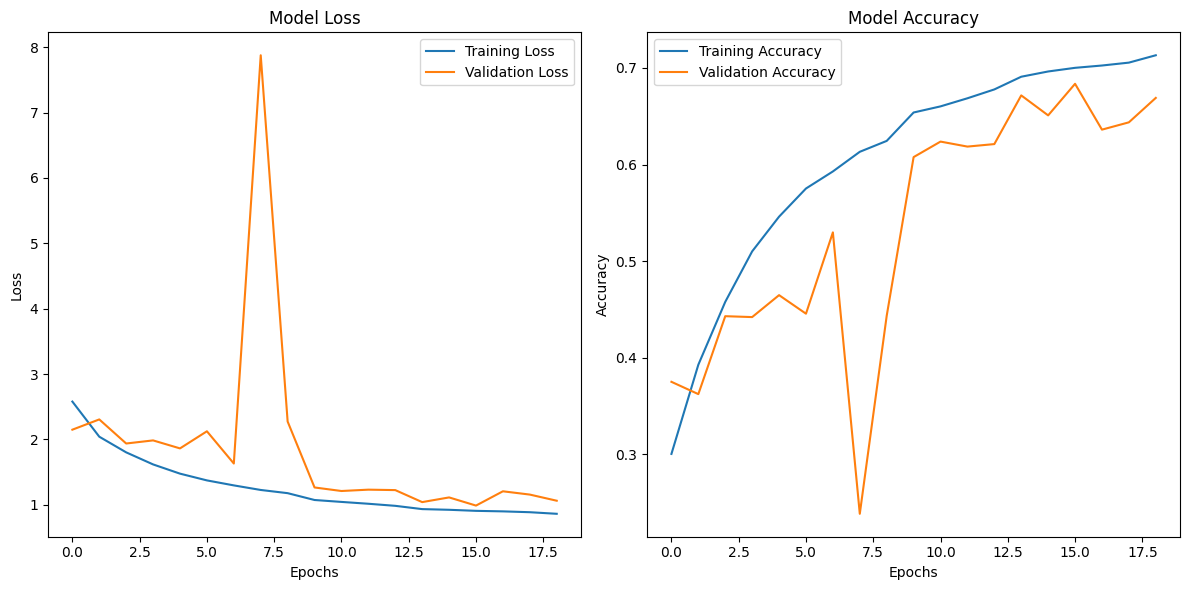

In [84]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

In [85]:
# Generate Predictions on Test Set
from tensorflow.keras import Sequential
import keras

with keras.utils.custom_object_scope({'Sequential': Sequential}):
    model = keras.models.load_model('best_model_wo_augmentation.h5')
y_true = []
y_pred = []
y_score = []
for images, labels in ds_test_ohe:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [86]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.681077
Precision: 0.638442
Recall: 0.681077
F1-score: 0.640867


c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


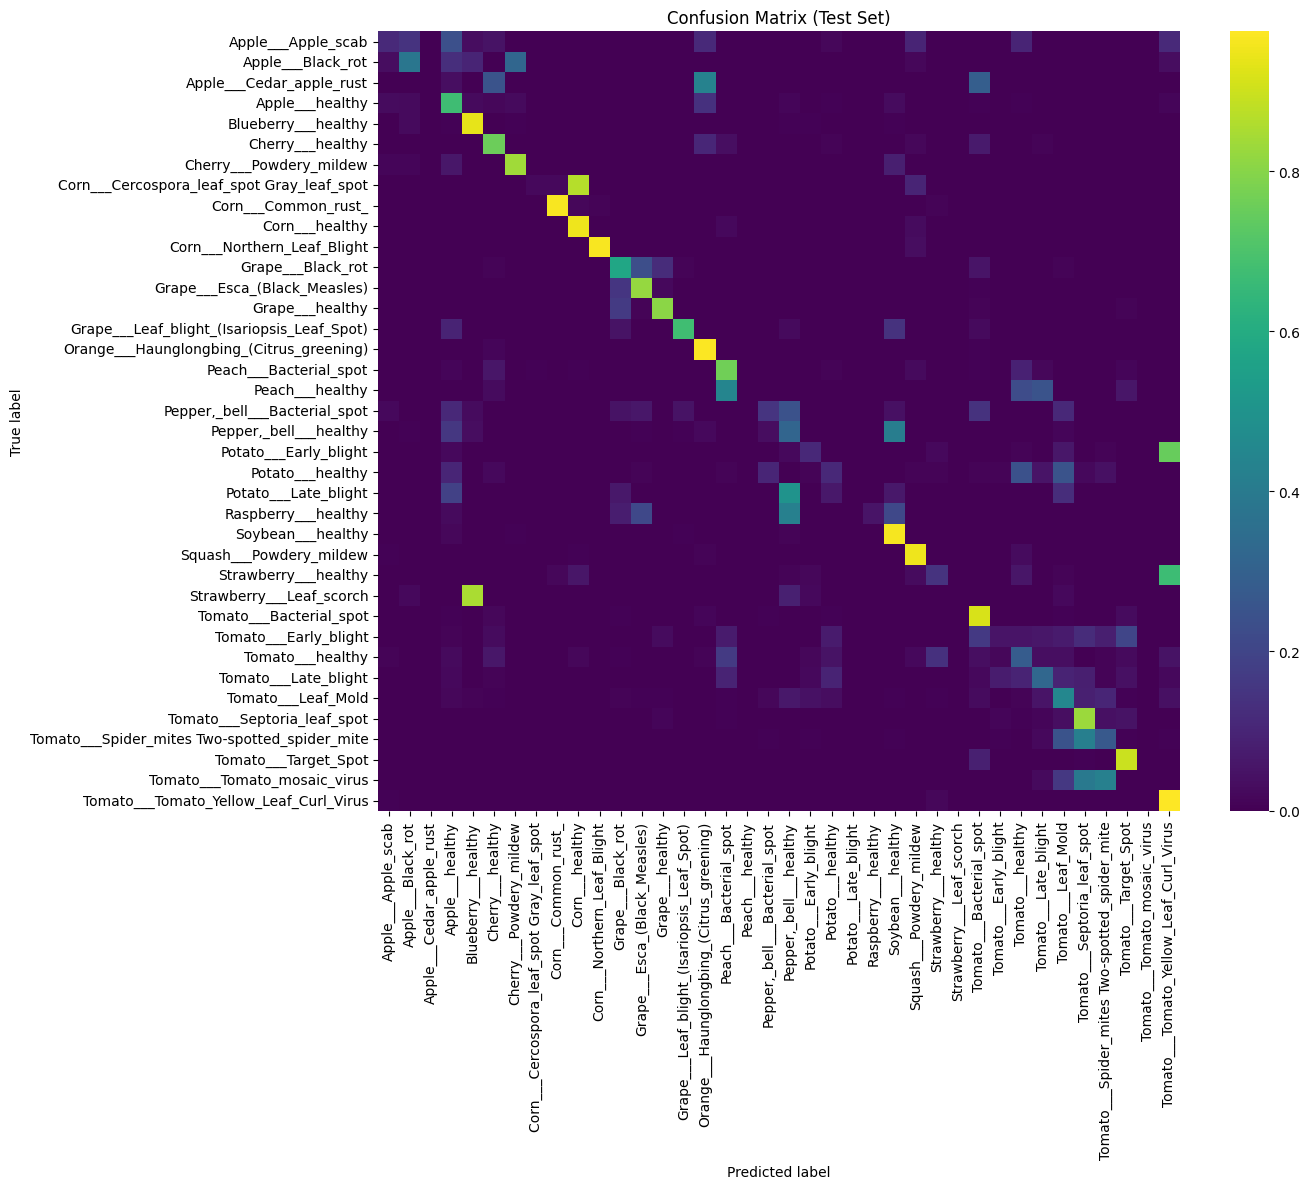

In [87]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

#Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
            xticklabels=split_labels, yticklabels=split_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [88]:
print(y_score.shape[1])


38


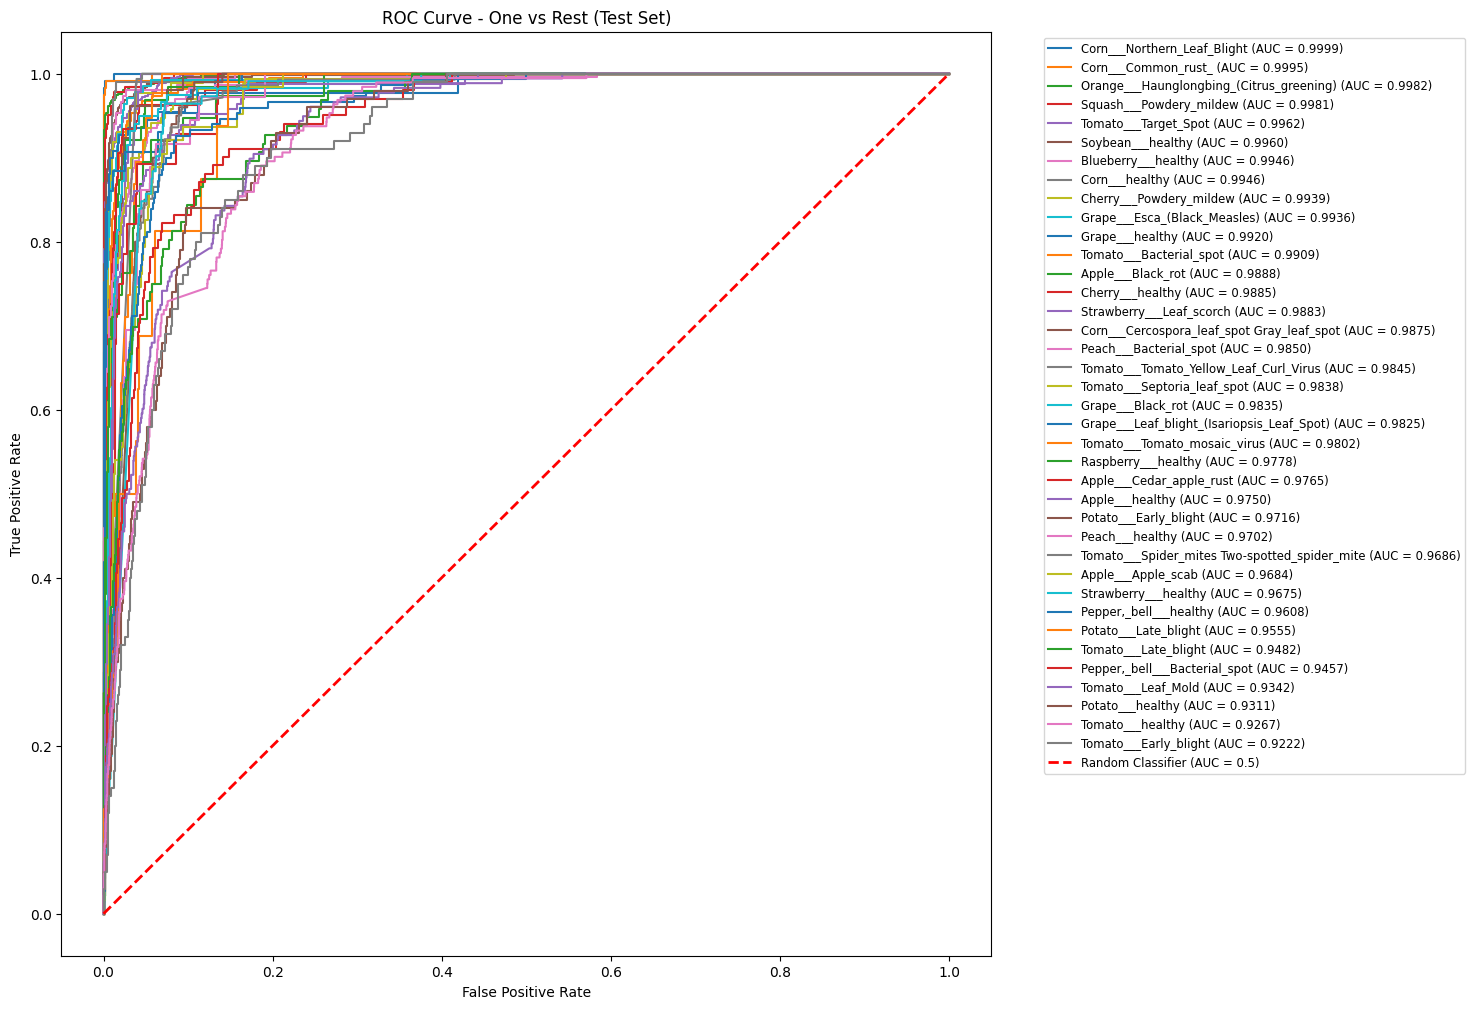

In [89]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{split_labels[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()


In [90]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=split_labels)
print(report)


                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.33      0.11      0.17        63
                            Apple___Black_rot       0.55      0.38      0.45        63
                     Apple___Cedar_apple_rust       0.00      0.00      0.00        28
                              Apple___healthy       0.50      0.67      0.58       165
                          Blueberry___healthy       0.70      0.94      0.80       151
                             Cherry___healthy       0.58      0.75      0.65       106
                      Cherry___Powdery_mildew       0.72      0.84      0.77        86
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.50      0.02      0.04        52
                          Corn___Common_rust_       0.97      0.97      0.97       120
                               Corn___healthy       0.62      0.95      0.75        99
                  Corn___Northern_Leaf_Bli

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

# Previous evaluation code

In [ ]:
# Plot ROC AUC for each class (one-vs-rest)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the test set
y_true = []
y_score = []

for images, labels in ds_test_fam:
    y_true.append(labels.numpy())
    y_score.append(model.predict(images))

y_true = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# Compute ROC AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_score[:, i])


In [ ]:
print(y_true.shape)


In [ ]:
# Plot ROC curve for each class, legend sorted by AUC score
plt.figure(figsize=(12, 12))

# Prepare list of (auc, i) and sort descending
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)

for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{families[i]} (AUC = {auc:.5f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
# Plot confusion matrix for the test set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true and predicted labels for the test set
y_true = []
y_pred = []

for images, labels in ds_test_fam:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')


In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
            xticklabels=families, yticklabels=families)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


# Load the best model